# MHC class I genotype vs % of people with CH

## Set up

In [1]:
# imported packages
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as plticker
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib.patches import Polygon
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib import cm
import scipy.special
import scipy.integrate as it
from scipy import integrate
from scipy.interpolate import interp1d
from scipy.stats import kde
import copy
import glob, os
import re
# from sklearn import datasets, linear_model
import pandas as pd
from decimal import *
from operator import itemgetter    
from collections import OrderedDict
import timeit
import time 
import csv
import seaborn as sns 
import scipy as sp
from sklearn.preprocessing import LabelEncoder
from matplotlib.ticker import LogLocator
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D

from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
from myfunctions import transform_format


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:

axisfont=11
titlefont=20
subtitlefont = 15
axislabelfont=12
legendfont = 11
tpfont = 12
plt.rcParams.update({'font.sans-serif':'Arial'})

In [3]:

timestr = time.strftime("%Y%m%d") # get current date 

## Import batch data

In [4]:

folder_path = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ukb_hotspot_calls_annotated'  # Path to ukb files from Hamish 

# Get all files in the folder 
files = glob.glob(os.path.join(folder_path, '*.txt'))  
# print('Files examined are:', files)

# Initialize an empty dictionary 
dataframes = {}

# Iterate through the CSV files and read each one with pandas
for csv_file in files:
    
    df = pd.read_csv(csv_file, sep = '\t')
    dataframes[csv_file] = df

# Extract dataframes 
for file_name, df in dataframes.items():
    
    variable_name = file_name.split('/')[8].split('.')[0] + '_data'  # Removing the file extension
    print('Examined file:', variable_name)
    
    df['batch'] = variable_name # add column to indicate source 
    globals()[variable_name] = df  # assign dataframe to the variable 


# Concat all into one df
dfs_to_concat = [v for k, v in globals().items() if k.endswith('_data') and isinstance(v, pd.DataFrame)]

# Row bind all batch dataframes into a single one 
batch_all = pd.concat(dfs_to_concat, ignore_index=True)
batch_all = batch_all.dropna(subset=['batch']) # remove rows which are read incorrectly (w/o batch number)

print('Number of samples with variants examined:', batch_all.shape[0])


Examined file: batch_21_annotated_data
Examined file: batch_18_annotated_data
Examined file: batch_15_annotated_data
Examined file: batch_11_annotated_data
Examined file: batch_16_annotated_data
Examined file: batch_12_annotated_data
Examined file: batch_13_annotated_data
Examined file: batch_17_annotated_data
Examined file: batch_14_annotated_data
Examined file: batch_19_annotated_data
Examined file: batch_20_annotated_data
Number of samples with variants examined: 76718


In [5]:

# Change numerical variables to integers

batch_all['end_position'] = batch_all['end_position'].astype(int)
batch_all['position'] = batch_all['position'].astype(int)
batch_all['sample_ID'] = batch_all['sample_ID'].astype(int)

# Subset and create new useful columns

batch_all = batch_all[['sample_ID', 'chromosome', 'end_position', 'VAF', 'var_depth', 'depth', 'Amino_acids', 'SYMBOL', 'Codons', 'batch']]
batch_all['alt_variant'] = batch_all['Amino_acids'].str.split('/', expand = True)[1] # alternative (CH) variant
batch_all['ref_variant'] = batch_all['Amino_acids'].str.split('/', expand = True)[0] # reference variant 

# There are some cases where there is no change in amino acids, for now save as NaN 

batch_all['alt_variant'].fillna(batch_all['Amino_acids'], inplace=True)
batch_all['ref_variant'].fillna(batch_all['Amino_acids'], inplace=True)

# Exclude data with singletons (likely errors)

batch_all_ns = batch_all[batch_all['var_depth'] >= 2]

# Number of samples with two variant reads or more 
print('Number of samples carrying more than a single read with the variant sequence:', batch_all_ns.shape[0])
# okay so we have 2823 of these but then note that only 2249 are with CH variants 
# so like 20% of >= 2 reads are not v likely to be real? should conslut with Jamie 

batch_all_ns.head(n = 10)

Number of samples carrying more than a single read with the variant sequence: 2823


,sample_ID,chromosome,end_position,VAF,var_depth,depth,Amino_acids,SYMBOL,Codons,batch,alt_variant,ref_variant
41,2100538,chr17,7674894,0.036364,2,55,R/*,TP53,Cga/Tga,batch_21_annotated_data,*,R
56,2100679,chr2,25234373,0.048780,4,82,R/H,DNMT3A,cGc/cAc,batch_21_annotated_data,H,R
59,2100706,chr2,25234307,0.019417,2,103,P/L,DNMT3A,cCg/cTg,batch_21_annotated_data,L,P
64,2100777,chr2,25240313,0.020833,2,96,R/*,DNMT3A,Cga/Tga,batch_21_annotated_data,*,R
65,2100788,chr2,25240420,0.131148,8,61,Y/C,DNMT3A,tAc/tGc,batch_21_annotated_data,C,Y
83,2101006,chr2,25240420,0.027778,2,72,Y/S,DNMT3A,tAc/tCc,batch_21_annotated_data,S,Y
109,2101361,chr17,76736877,0.025641,2,78,P/H,SRSF2,cCc/cAc,batch_21_annotated_data,H,P
126,2101637,chr2,25240313,0.021739,2,92,R/*,DNMT3A,Cga/Tga,batch_21_annotated_data,*,R
130,2101708,chr17,7675088,0.033898,2,59,R/H,TP53,cGc/cAc,batch_21_annotated_data,H,R
154,2102011,chr15,90088702,0.097561,4,41,R/Q,IDH2,cGg/cAg,batch_21_annotated_data,Q,R


In [6]:

# Import indexes tested in each batch 
folder_path = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ukb_hotspot_calls/batch_ids'  # Path to ukb files from Hamish 

# Get all files in the folder 
files_ids = glob.glob(os.path.join(folder_path, '*.tsv'))  

# Read each file one by one 

indexes = {}

# Iterate through the CSV files and read each one with pandas
for file in files_ids:
    
    id = pd.read_csv(file, sep = '\t')
    id = id.rename(columns={'batch ID': 'sample_ID'})
    id['sample_ID'] = id['sample_ID'].str.split('_', n = 1).str[0]
    indexes[file] = id

for file_name, df in indexes.items():
    
    variable_name = file_name.split('/')[9].split('.')[0]    # Remove file extension
    globals()[variable_name] = df  # Assign the DataFrame to a variable with the file name


## Annotate samples with genetic variants carried 

In [7]:

# Find out how many gene_variants were called:

# don't show warnings 
import warnings
warnings.filterwarnings("ignore")

# identify variants called 
batch_all_ns['variant_coord'] = batch_all_ns['chromosome'].astype(str) + "_" + batch_all_ns['end_position'].astype(str) # specific position in the genome 
batch_all_ns['variant_coord'] = batch_all_ns['variant_coord'].astype('category')
batch_all_ns['variant_coord_pos'] = batch_all_ns['variant_coord'].astype(str) +  "_" + batch_all_ns['SYMBOL'].astype(str) + "_" + batch_all_ns['ref_variant'].astype(str) + "_" + batch_all_ns['alt_variant'].astype(str) # change to a specific aa
batch_all_ns['variant_coord_pos'] = batch_all_ns['variant_coord_pos'].astype('category')

# remove samples that have not been annotated (you can tell from the coordinate what is likely but these could be different mutations)
batch_all_ns = batch_all_ns.dropna(subset=['SYMBOL']) # remove column where gene is not known 
print('Number of samples which have been correctly annotated:', batch_all_ns.shape[0]) # but at each site, you are getting reads modified to sth else 
# ok so sth worked wrong with annotation in only 5 cases > that looks good 

# identify the number of variants in a specific position
num_variants = pd.DataFrame(batch_all_ns['variant_coord_pos'].value_counts())
num_variants = num_variants[num_variants['count']!=0]
num_variants = num_variants.sort_values(by = 'count')
num_variants['variant_coord_pos'] = num_variants.index
num_variants = num_variants.reset_index(drop=True)
num_variants = num_variants.sort_values(by = 'variant_coord_pos')
print('Number of variants identified in batches analysed:', num_variants.shape[0]) # but at each site, you are getting reads modiifed to sth else 

# identify the number of positions we looked at
num_sites = pd.DataFrame(batch_all_ns['variant_coord'].value_counts())
num_sites = num_sites[num_sites['count']!=0]
num_sites = num_sites.sort_values(by = 'count')
num_sites['variant_coord'] = num_sites.index
num_sites = num_sites.reset_index(drop=True)
num_sites = num_sites.sort_values(by = 'variant_coord')
print('Number of sites identified in batches analysed:', num_sites.shape[0]) # okay see so you only found 37 sites 

# we have more variants than sites because for each site, we look at any change from the reference sequence (any possible variant)
# at the same time, because we have this data, we can check if we have more variants that "random" mutations

# save coordinates to a df
pd.DataFrame(num_variants.variant_coord_pos.unique().tolist()).to_csv('/Users/barbarawalkowiak/Desktop/variants_annotated.csv')

Number of samples which have been correctly annotated: 2818
Number of variants identified in batches analysed: 89
Number of sites identified in batches analysed: 41


In [8]:

# Annotation (using df with variant names and genomic coordinates)

# read in the df with coordinates
coord_gene_var = pd.read_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ch_variants_coordinates_tp53_added_nts.csv')

# all coordinates identified in the batches  
coord_out = num_sites['variant_coord'].tolist()

# intersection (annotate)
coord_gene_var['variant_coord'] = coord_gene_var['chromosome'] + "_" + coord_gene_var['end_position'].astype(str) # find cariant coordinates
coord_gene_var['SYMBOL'] = coord_gene_var['gene_var'].str.split('_').str[0] # find gene analysed
coord_gene_var['ref_variant'] = coord_gene_var['gene_var'].str.split('_').str[1].str[0] # reference sequence variant 
coord_gene_var['alt_variant'] = coord_gene_var['gene_var'].str.split('_').str[1].str[-1] # alternative sequence (CH / mutation) variant
coord_gene_var['variant_coord_pos'] = coord_gene_var['variant_coord'].astype(str) + "_" + coord_gene_var['SYMBOL'].astype(str) + "_" + coord_gene_var['ref_variant'].astype(str) + "_" + coord_gene_var['alt_variant'].astype(str) # specific mutation 

print('Number of variants which have been investigated:', len(coord_gene_var.variant_coord_pos.unique()))
print('Number of sites which have been investigated:',len(coord_gene_var.variant_coord.unique()))

# NB we removed one variant bc the coordinates were incorrect

# NOTE: 
# TP53_R249S was searched for but not found in any of the batches so far 
# there have been 5 samples identified (in DNMT3A, at 2 different sites) with variants that I did not originally search for 
# in addition, some of the variants were offset by one base (could have been a deletion / insertion)
# this is why we have differences in the number of sites in the two datasets 


Number of variants which have been investigated: 42
Number of sites which have been investigated: 36


In [9]:

# identify CH variants typed in the dataset 
gene_vars = coord_gene_var[['variant_coord_pos', 'gene_var']]

# subset batch df to only include variants which were successfully identified 
batch_gene_vars = pd.merge(batch_all_ns, gene_vars, on = 'variant_coord_pos', how = 'inner')
batch_gene_vars['gene_var'] = batch_gene_vars['gene_var'].astype('category')
batch_gene_vars['gene_var'].value_counts()

gene_vars_count = pd.DataFrame(batch_gene_vars['gene_var'].value_counts())
gene_vars_count['gene_var'] = gene_vars_count.index
gene_vars_count = gene_vars_count.reset_index(drop=True)
gene_vars_sorted = gene_vars_count.sort_values(by = 'count', ascending=False)

print('Number of variants identified with annotations:', gene_vars_sorted.shape[0])
# so we will have 30 variants to look at bc the rest was not mapped correctly 

print('Number of samples with a mutation in a CH-relevant position (with >2 reads):', batch_all_ns.shape[0])
print('Number of patients with a mutation in a CH-relevant position (with >2 reads):', len(batch_all_ns.sample_ID.unique()))
print('Number of samples with a CH hotspot mutation (with > 2 reads):', batch_gene_vars.shape[0])
print('Number of patients with a CH hotspot mutation (with > 2 reads):', len(batch_gene_vars.sample_ID.unique()))


Number of variants identified with annotations: 32
Number of samples with a mutation in a CH-relevant position (with >2 reads): 2818
Number of patients with a mutation in a CH-relevant position (with >2 reads): 2761
Number of samples with a CH hotspot mutation (with > 2 reads): 2249
Number of patients with a CH hotspot mutation (with > 2 reads): 2214


In [13]:

# Filtering 2: we will only be looking at variants for which we have more than 10 samples 
gene_vars_count = pd.DataFrame(batch_gene_vars['gene_var'].value_counts())
gene_vars_count['gene_var'] = gene_vars_count.index
gene_vars_count = gene_vars_count.reset_index(drop=True)
gene_vars_sorted = gene_vars_count.sort_values(by = 'count', ascending=False)

variants_to_examine = gene_vars_sorted[gene_vars_sorted['count'] >= 10].gene_var.tolist()
print('Number of variants to examine (min 10 samples with variant identified):', len(variants_to_examine))

# filter the dataframe to only include CH variants with minimum 10 samples 
batch_gene_vars_10 = batch_gene_vars[batch_gene_vars['gene_var'].isin(variants_to_examine)]
print('Number of samples with reasonably common variants (min 10 samples with variant identified):', batch_gene_vars_10.shape[0])

Number of variants to examine (min 10 samples with variant identified): 22
Number of samples with reasonably common variants (min 10 samples with variant identified): 2196


## Add age data 

In [10]:

# load the age dataset 
age_data = pd.read_csv('~/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/2022-05-20_healthy_pheno.tsv', sep = '\t')

age_df = age_data[['ID_v0', 'Age.when.attended.assessment.centre_v0']]
age_df.columns.values[0] = 'sample_ID'
age_df.columns.values[1] = 'age'
print('Number of individuals for whom age data is available:', age_df.shape[0])

Number of individuals for whom age data is available: 459385


In [15]:

# add age data to the rest of the data 

batch_gene_age = pd.merge(batch_gene_vars, age_df, on = 'sample_ID') # add age to everyone who has a variant
print("Number of sample with available CH variant:", batch_gene_vars.shape[0])
print("Number of sample with available CH variant and age:", batch_gene_age.shape[0])
# note: this is throwing away patients who have been diagnosed with cancer (this dataset is for healthy individuals only)

batch_gene_age_10 = pd.merge(batch_gene_vars_10, age_df, on = 'sample_ID') # add age to everyone who has a variant
print("Number of sample with available CH variant (for more common variants):", batch_gene_vars_10.shape[0])
print("Number of sample with available CH variant and age (for more common variants):", batch_gene_age_10.shape[0])

# I think excluding these variants does not make a massive difference to the number of datapoints we have
# At the same time, we cannot draw any conclusion from variants with < 10 samples so I think this is totally justified 

Number of sample with available CH variant: 2249
Number of sample with available CH variant and age: 1986
Number of sample with available CH variant (for more common variants): 2196
Number of sample with available CH variant and age (for more common variants): 1938


# Load MHC bindng affinity prediction

In [16]:

# need to change format of HLA allele name to align with HLA genotyping file

import re

# transform format (from NetMHCpan data to UKBB format)
def transform_format_netmhc(input_string):
    # a regular expression pattern to match the input format
    pattern = re.compile(r'HLA-(\w\S*)(\d{2}):(\d{2})')

    # check if there is a match
    match = pattern.match(input_string)

    # if match, apply transformation
    if match:
        group1 = match.group(1).replace('*', '') # remove the star 
        group2 = int(match.group(2)) # remove zeros at the start 
        group3 = match.group(3) # leave as it is 

        # Format the output string
        output_string = f'{group1}_{group2}{group3}' # stitch back 
        return output_string # return transformed string 

    # if no much, return original string 
    return input_string

# transform format (from NetMHCpan data to UKBB format) - VERY annoyingly running the same pipeline I can get different formats of HLA allele names
def transform_format_netmhc_2(input_string):
    # a regular expression pattern to match the input format
    pattern = re.compile(r'HLA-(\w)(\d{2}):(\d{2})')

    # check if there is a match
    match = pattern.match(input_string)

    # if match, apply transformation
    if match:
        group1 = match.group(1) # remove the star 
        group2 = int(match.group(2)) # remove zeros at the start 
        group3 = match.group(3) # leave as it is 

        # Format the output string
        output_string = f'{group1}_{group2}{group3}' # stitch back 
        return output_string # return transformed string 

    # if no much, return original string 
    return input_string

# transform format (from PRIME format to UKBB format)
def transform_format_prime(input_string):
    # regular expression pattern to match the input format
    # Nb PRIME is almost the same as NetMHC but there is no star after "HLA-A*"
    pattern = re.compile(r'HLA-(\w)(\d{2}):(\d{2})')

    # check if there is a match
    match = pattern.match(input_string)

    # if match, apply transformation
    if match:
        group1 = match.group(1).replace('*', '') # remove the star 
        group2 = int(match.group(2)) # remove zeros at the start 
        group3 = match.group(3) # leave as it is 

        # Format the output string
        output_string = f'{group1}_{group2}{group3}' # stitch back 
        return output_string # return transformed string 

    # if no much, return original string 
    return input_string

In [17]:

# Import PRIME and NetMHC data 

pred_file_net = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/netMHC_out/scores/20240210_NetMHC_HLA_UKBB_with_affinities_bestscores.csv' # EL scores, BA scores, EL rank, BA rank, affinity prediction
pred_file_net2 = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/netMHC_out/scores/20240221_percent_ranks_for_each_variant_by_HLA.csv' # EL rank, sum of weakly binding peptides, sum of strongly binding peptides
pred_file_prime = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/PRIME_out/scores/20240220_percent_ranks_for_each_variant_by_HLA.csv' # prediction file for PRIME

pred_filename_net = pred_file_net.split('/')[2].split('.')[0]
pred_filename_net2 = pred_file_net2.split('/')[2].split('.')[0]
pred_method_net = pred_file_net.split('_out')[0]
pred_filename_prime = pred_file_prime.split('/')[2].split('.')[0]
pred_method_prime = pred_file_prime.split('_out')[0]

# Organize NetMHC scores 
netmhc = pd.read_csv(pred_file_net)
netmhc2 = pd.read_csv(pred_file_net2)

# in the original file, I am using "STOP" to indicate stop codons
# I need to change it to "*" to ensure consistent names for variants 
netmhc2['variant'] = netmhc2['variant'].str.replace('STOP', '*')

# rename collumns in NetMHC
netmhc = netmhc.rename(columns={'Aff(nM)': 'Aff_nM'}) # rename affinity column 
netmhc2 = netmhc2.rename(columns={'allele': 'HLA'}) # rename affinity column 
netmhc2 = netmhc2.rename(columns={'min_rank': '%Rank_EL_2'}) # rename affinity column 

# uniform HLA allele naming format
NET_col = netmhc.HLA
NET_formatted = NET_col.apply(transform_format_netmhc)
netmhc = pd.concat([netmhc, NET_formatted.rename('HLA_formatted')], axis = 1)
NET_col2 = netmhc2.HLA
NET_formatted2 = NET_col2.apply(transform_format_netmhc_2)
netmhc2 = pd.concat([netmhc2, NET_formatted2.rename('HLA_formatted')], axis = 1)

# select required columns
netmhc = netmhc[['HLA_formatted', 'Peptide', '%Rank_EL', 'Score_EL', '%Rank_BA', 'Score_BA', 'Aff_nM', 'gene', 'variant', 'genotype']]
netmhc2 = netmhc2[['HLA_formatted', '%Rank_EL_2', 'sum_peptides_below_05', 'sum_peptides_below_2', 'gene', 'variant', 'genotype']]

# sort both dataframes so that is easier to compare values
netmhc = netmhc.sort_values(by=['HLA_formatted', 'gene', 'variant', 'genotype'])
netmhc2 = netmhc2.sort_values(by=['HLA_formatted', 'gene', 'variant', 'genotype'])

# merge two dataframes for netmhc
netmhc_all = pd.merge(netmhc, netmhc2, on = ['HLA_formatted', 'gene', 'variant', 'genotype'])

netmhc_all['gene_var_gt'] = netmhc_all['gene'] + '_' + netmhc_all['variant'] + '_' + netmhc_all['genotype'] # add complete genotype data
netmhc_all['gene_var'] = netmhc_all['gene'] + '_' + netmhc_all['variant']
netmhc_all = netmhc_all.rename(columns={'Aff(nM)': 'Aff_nM'}) # rename affinity column 
scores_netmhc = netmhc_all[['HLA_formatted', 'Score_EL', '%Rank_EL', 'Score_BA', '%Rank_BA', 'Aff_nM', 'gene_var', 'gene_var_gt']] # select columns of interest

# Organize PRIME scores 
prime = pd.read_csv(pred_file_prime)
# variants with stop codons are indicated with AposSTOP 
# this is because I couldn't write anything with * (did not accept * in path)
prime['variant'] = prime['variant'].str.replace('STOP', '*')
prime['gene_var_gt'] = prime['gene'] + '_' + prime['variant'] + '_' + prime['genotype'] # add complete genotype data
prime['gene_var'] = prime['gene'] + '_' + prime['variant']
prime = prime.rename(columns={'allele': 'HLA'}) # rename affinity column 
prime = prime.rename(columns={'min_rank': '%Rank_EL'}) # rename affinity column 

# remove columns with duplicated variants (for stop codons)
stop_to_remove = ['TP53_R213S', 'TP53_R196S', 'DNMT3A_R598S', 'DNMT3A_R771S', 'DNMT3A_R320S']
prime = prime[~prime['gene_var'].isin(stop_to_remove)]

# uniform HLA allele naming format
PRIME_col = prime.HLA
PRIME_formatted = PRIME_col.apply(transform_format_prime)
prime = pd.concat([prime, PRIME_formatted.rename('HLA_formatted')], axis = 1)

scores_prime = prime[['HLA_formatted', '%Rank_EL', 'gene', 'variant', 'genotype', 'gene_var_gt']] # select columns of interest

# Print the results 
print('Number of alleles for which predictions are available (NetMHC):', len(netmhc_all.HLA_formatted.unique()))
print('Number of unique variants (NetMHC):',  len(netmhc_all.gene_var.unique()))
print('Number of alleles for which predictions are available (PRIME):', len(prime.HLA_formatted.unique()))
print('Number of unique variants (PRIME):',  len(prime.gene_var.unique()))


Number of alleles for which predictions are available (NetMHC): 194
Number of unique variants (NetMHC): 42
Number of alleles for which predictions are available (PRIME): 194
Number of unique variants (PRIME): 42


# Load MHC class I genotyping data

In [18]:

# add MHC genotype data to CH cases

# path to file
file_hla = "/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/UKBB/ukb_typed_hla_with_ids_07_threshold_processed.txt"

# get the header 
header = pd.read_csv(file_hla, sep='\t', nrows=1, header=None).values.tolist()
head = [item for sublist in header for item in sublist]

# get the actual dataframe 
df = pd.read_csv(file_hla, skiprows = 1, sep = ' ', header = None)

# add columns 
df.columns = head 

# subset data for HLA-I and HLA-II class alleles 
# we are only interested in HLA-I for the momnet 
df_hla1 = df.filter(regex='^(Person_|A_|B_|C_)') # 488377 cases 
df_hla2 = df.filter(regex='^(Person_|D)') # 488377 cases 

# clean up the dataset (filtering according to Krishna et al., 2024 Science)
df_clean_hla1 = df_hla1[~df_hla1.isin([0.5]).any(axis=1)] # exclude people for whom we lacked a genotype
df_clean_hla1 = df_clean_hla1[~df_clean_hla1.isin([1.5]).any(axis=1)] # exclude people for whom we lacked a genotype

print("Number of samples with imputed HLA:", df_hla1.shape[0])
print("Number of samples with confidently imputed HLA:", df_clean_hla1.shape[0])

Number of samples with imputed HLA: 488377
Number of samples with confidently imputed HLA: 443620


In [19]:

# now you need to merge the data that you want to use with the allele data to get predictions
# most comprehensive dataset we have is batch_gene_age (includes genetic variant someone carries and age)
# Find IDs of CH-affected persons and match to their HLA genotype 

batch_gene_vars.rename(columns={'sample_ID': 'Person_ID'}, inplace=True)
batch_gene_age.rename(columns={'sample_ID': 'Person_ID'}, inplace=True)
ids_batch = batch_gene_age['Person_ID']
hla_batch_ids = df_clean_hla1[df_clean_hla1['Person_ID'].isin(ids_batch)] 

# add HLA genotype data to samples with annotated CH variant and age
batch_gene_age_hla = pd.merge(batch_gene_age, df_clean_hla1, on='Person_ID')
batch_gene_vars_hla = pd.merge(batch_gene_vars, df_clean_hla1, on='Person_ID')
print("Number of samples with available CH variant:", batch_gene_vars.shape[0])
print("Number of samples with available CH variant and HLA genotype:", batch_gene_vars_hla.shape[0])
print("Number of samples with available CH variant and age:", batch_gene_age.shape[0])
print('Number of samples with annotated variants CH variant and age and HLA genotype:', batch_gene_age_hla.shape[0]) # 1 HLA genotype missing 

# first, filter the df such that we only have MHC alleles for which predictions are available 
hla_ukbb = df_clean_hla1.filter(regex='\d').columns # HLA from all UKBB
print('Number of HLA alleles which have been identified in the UK BioBank:', len(hla_ukbb))


Number of samples with available CH variant: 2249
Number of samples with available CH variant and HLA genotype: 2043
Number of samples with available CH variant and age: 1986
Number of samples with annotated variants CH variant and age and HLA genotype: 1798
Number of HLA alleles which have been identified in the UK BioBank: 214


In [20]:

# define the function to find best score for variant carried by someone
def find_best_score_for_variant_carried(row, df, param):
    
    row_values = pd.to_numeric(row[1:-2], errors='coerce')
    
    # find alleles which are present 
    hla = row.index[1:-2][row_values >= 1] 
    
    # find values corresponding to these alleles 
    vals = df.loc[df['gene_var'] == row['gene_var'], hla].values.flatten() 
    # print(vals)
    # print(type(vals))
    # it can be that nothing was found e.g., bc there were no predictions made for this variant
    if vals.size == 0: 
        value = None
    
    else: 
    
        if param == "Aff_nM":
            value = min(vals) # highest affinity corresponds to lowest value (see plots above)
        elif param == "%Rank_EL":
            value = min(vals) # the best rank is the lowest one (indicates peptide in top x % of binders)
        elif param == "Score_EL":
            value = max(vals) # the best score is the highest one 
        elif param == "%Rank_BA":
            value = min(vals) # the best rank is the lowest one (indicates peptide in top x % of binders)
        elif param == "Score_BA":
            value = max(vals) # the best score is the highest one
        else:
            print('Incorrect parameter provided') 
    
    return value   


In [21]:

# get predictions

# define a function to obtain dataframes with predictions for different scores 
def pred_to_scores(df, param):

    '''
    Allowed parameters are:
    Aff_nM - affinity (raw number)
    Score_BA - binding affinity score
    Score_EL - elution score
    %Rank_BA - %Rank of binding affinity cf a set of random peptides
    %Rank_EL - %Rank of elution cf a set of random peptides
    '''

    # for a given parameter, prepare a dataframe where you store the genetic variant and best score for each HLA allele
    pred_sub = df[['HLA_formatted', 'gene_var_gt', param]]
    pred_sub_wide = pd.pivot(pred_sub, index='gene_var_gt', columns='HLA_formatted', values=param)
    pred_sub_wide = pred_sub_wide.reset_index() # this is to make sure that you have the gene_var column in there too 
    
    # create a list of HLA alleles genotyped in the UKBB for which predictions are available
    hla_intersect = pred_sub_wide.columns[pred_sub_wide.columns.isin(hla_ukbb)] # HLA in the UKBB which I have predictions for 
    hla_intersect_list = hla_intersect.tolist() 

    # subset predictions to only include scores for available 
    pred_sub = pred_sub_wide[hla_intersect_list + pred_sub_wide.columns[pred_sub_wide.columns.str.contains('gene_var')].tolist()]

    # prepare gene variants names to match names in the Patient file 
    pred_sub = pred_sub[pred_sub['gene_var_gt'].str.contains('_ch', regex=True)] # retain CH scores only 
    pred_sub['gene_var'] = pred_sub['gene_var_gt'].str.replace('_ch', '') # remove the ch / refseq annotation
    pred_sub['gene_var'] = pred_sub['gene_var'].str.replace('_refseq', '') # remove refseq if present 

    # subset batch_gene_age_hla file 
    ch_hla_sub = batch_gene_age_hla[hla_intersect_list + batch_gene_age_hla.columns[batch_gene_age_hla.columns.str.contains('gene_var')].tolist()]
    ch_hla_sub = pd.concat([batch_gene_age_hla["Person_ID"], ch_hla_sub], axis=1) # add CH cases 
    ch_hla_sub['score'] = ch_hla_sub.apply(find_best_score_for_variant_carried, df=pred_sub, param=param, axis=1) # add score for the parameter
    ch_hla_scores = ch_hla_sub.dropna() # remove NA (incorrectly annotated cases)

    # merge scores with VAF and age
    age_vaf = batch_gene_age_hla[['Person_ID', 'VAF', 'var_depth', 'age', 'gene_var']]
    ch_hla_merge = pd.merge(ch_hla_scores, age_vaf, on = ['Person_ID', 'gene_var'])

    # now add the columns with VAF and age 
    col_to_select = ['Person_ID', 'gene_var', 'score', 'age', 'var_depth', 'VAF'] # subset the data 
    ch_hla_merge_sub = ch_hla_merge[col_to_select]

    return ch_hla_merge_sub


In [22]:

# run the function 
param = '%Rank_EL' # allowed parameters (scores we are interested in)

# get individual dataframes
ch_best_el_rank = pred_to_scores(netmhc_all, param)
ch_best_el_rank['score_type'] = '%Rank_EL_NetMHC' # add so you can distinguish between NetMHC and PRIME as %Rank_EL is available for both

# for affinity and ranking, convert to negative log (higher -1log(rank) = tighter binding / more immunogenic)
ch_best_el_rank['log_score'] = -1*np.log10(ch_best_el_rank['score']) # convert score to -log10(score)

# we have done this for scores from NetMHC, but we can also add %Rank_EL from PRIME
prime_ch_best_el_rank = pred_to_scores(prime, param)
prime_ch_best_el_rank['score_type'] = '%Rank_EL_PRIME'
prime_ch_best_el_rank['log_score'] = -1*np.log10(prime_ch_best_el_rank['score'])


# MHC genotype > effect on CH risk 

In [23]:


# define a new function just to do it for one variant 
def find_best_score_one_variant_log_ref_ch(row, df, param, variant):
    
    '''
    The same function but log scores 
    the only allowed parameters are %Rank_EL and %Rank_BA
    we want -1 * log(score) so the highest score if the most "immunogenic" (best binding) one
    '''
    
    hlas = row.index[1:-1][row[1:-1] >= 1] # select alleles which each Person (row) carrie
    
    scores = {} # initialise empty dictionaries

    if param == "%Rank_EL":

        # take maximum of the negative log score 
        best_value = max(-1 * np.log10(df.loc[df['gene_var_gt'] == variant, hlas].values[0]))
        scores[f'score_{variant}'] = best_value
        return pd.Series(scores)

    elif param == "%Rank_BA":
        
        # take maxium of the negative log score 
        best_value = max(-1 * np.log10(df.loc[df['gene_var_gt'] == variant, hlas].values[0]))
        scores[f'score_{variant}'] = best_value
        return pd.Series(scores)

    elif param == "Aff_nM":
        
        # take maxium of the negative log score (low aff = more immunogenic)
        best_value = max(-1 * np.log10(df.loc[df['gene_var_gt'] == variant, hlas].values[0]))
        scores[f'score_{variant}'] = best_value
        return pd.Series(scores)


In [24]:

# define a function to split people into groups based on MHC presentation score 

def split_equal_groups_by_varscore(df, num_groups, var):

    # first, assign a rank to everyone based on score
    # the highest score = the lowest rank (ie highest score means you get rank 1)
    # if two people have the same score, assign consecutive ranks 
    
    # first, determine the number of samples
    total_samples = len(df)

    # now, determine the number of samples in each group
    samples_per_group = total_samples // num_groups
    remainder = total_samples % num_groups
    group_sizes = [samples_per_group + 1 if i < remainder else samples_per_group for i in range(num_groups)] # add one person if there is a reminder 
    
    # now, assign the group based on the rank 
    group_assignments = []
    group_number = 1
    start = 0
    for size in group_sizes:
        end = start + size
        group_assignments.extend([group_number] * (end - start))
        start = end
        group_number += 1

    # Add a new column 'group' to the DataFrame indicating the group assignment for each row
    return group_assignments


In [25]:

# we can add scores to EVERYONE we have HLA genotype for in the UKBB data (this is the df_hla dataset)

# cases who have CH with a genotyped variant (from one of the ones we were looking at) are in batch_gene_vars 

ch_sampleids = batch_gene_vars['Person_ID']
ukbb_no_ch = df_clean_hla1[~df_clean_hla1['Person_ID'].isin(ch_sampleids)]
hla_ukbb = ukbb_no_ch.filter(regex='\d').columns # identify HLA alleles carried by non-CH-individuals in the UKBB data

# prepare dataset with predictions (now just from NetMHC)
scores_netmhc_elrank = scores_netmhc[['HLA_formatted', '%Rank_EL', 'gene_var_gt']]
scores_netmhc_elrank_wide = pd.pivot(scores_netmhc_elrank, index='gene_var_gt', columns='HLA_formatted', values='%Rank_EL')

hla_intersect = scores_netmhc_elrank_wide.columns[scores_netmhc_elrank_wide.columns.isin(hla_ukbb)]
hla_intersect_list = hla_intersect.tolist() # select predictions for alleles which are available in NetMHC / PRIME

pred_sub_wide = scores_netmhc_elrank_wide[hla_intersect_list + scores_netmhc_elrank_wide.columns[scores_netmhc_elrank_wide.columns.str.contains('gene_var_gt')].tolist()]

ukbb_no_ch_hla = ukbb_no_ch[hla_intersect]
ukbb_no_ch = pd.concat([ukbb_no_ch['Person_ID'], ukbb_no_ch_hla], axis = 1)
ukbb_no_ch.head()

ids_non_carriers_healthy = ukbb_no_ch.Person_ID.unique().tolist()
print('Number of healthy (non-CH) individuals examined:', len(ids_non_carriers_healthy))

# okay so now we have a dataset for everyone who does NOT have CH
# and for all of them, we have their alleles for which we can make predictions

# I am stupid and I can't move the index to the column so sorry but I will just a new column
pred_sub_wide['gene_var_gt'] = pred_sub_wide.index

Number of healthy (non-CH) individuals examined: 441608


In [26]:
# select only HLAs for which we have predictions
df_clean_hla1_hla = df_clean_hla1[hla_intersect]
df_clean_hla1_hla_sel = pd.concat([df_clean_hla1['Person_ID'], df_clean_hla1_hla], axis = 1)

In [27]:
# we want to run the analysis only for variants which are present in at least 10 samples
# ie ignore variants for which you have 2-3 datapoints as they are not informative but add to the runtime and space (plots etc)

genevar_counts = pd.DataFrame(batch_gene_vars.gene_var.value_counts().reset_index())
variants_to_examine = genevar_counts[genevar_counts['count'] >= 10].gene_var.tolist()
print('Number of variants identified in at least 10 samples:', len(variants_to_examine))

Number of variants identified in at least 10 samples: 22


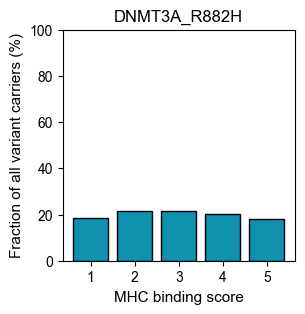

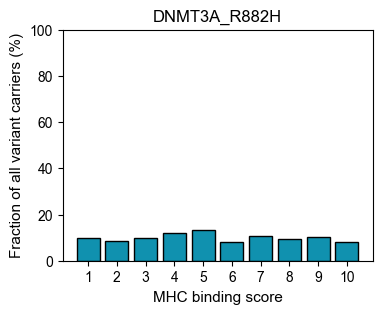

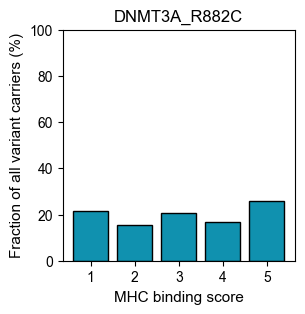

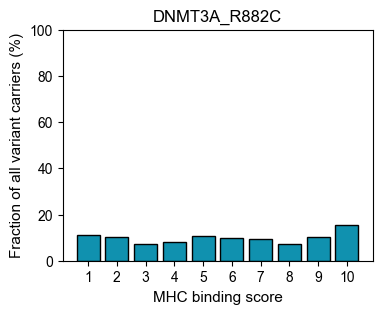

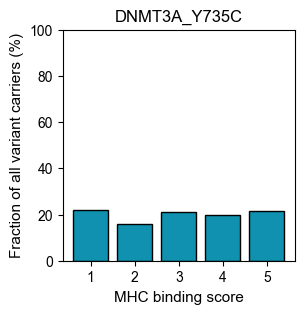

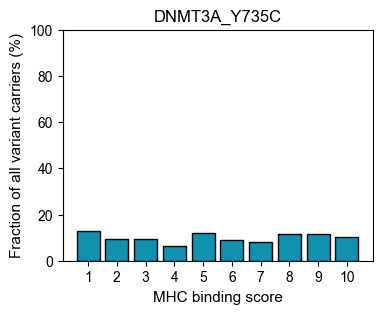

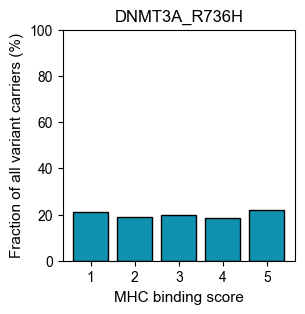

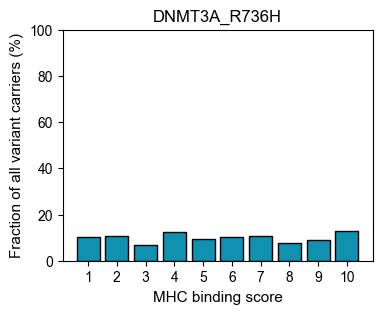

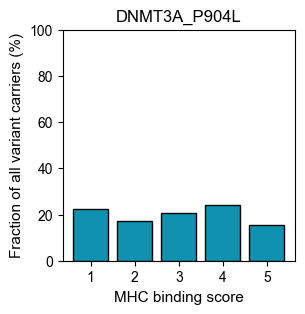

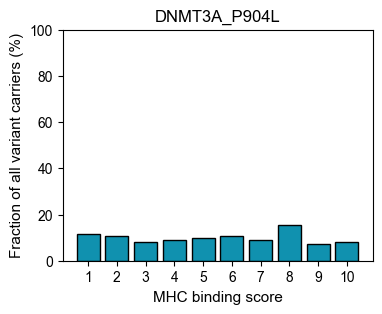

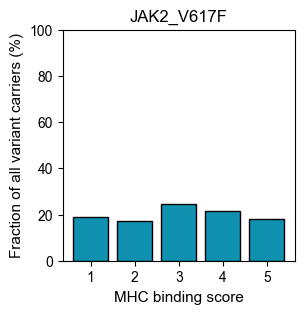

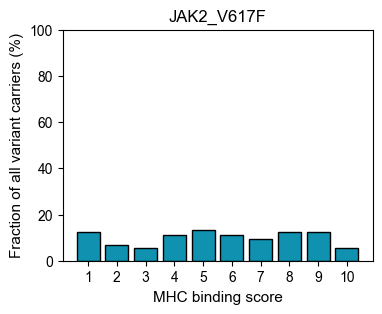

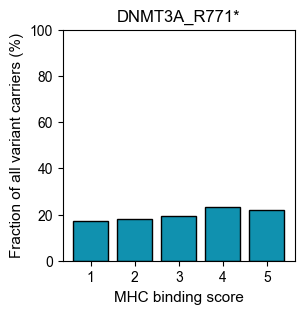

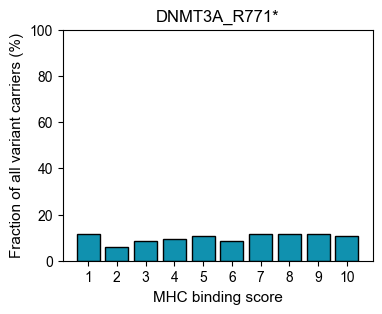

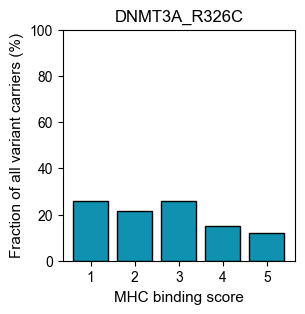

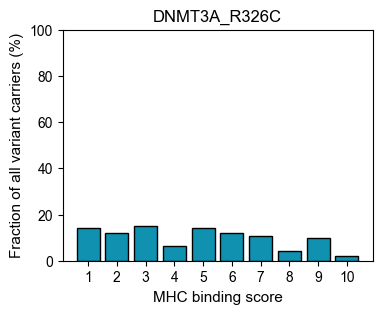

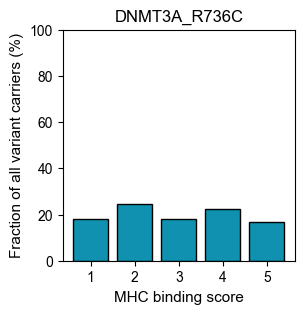

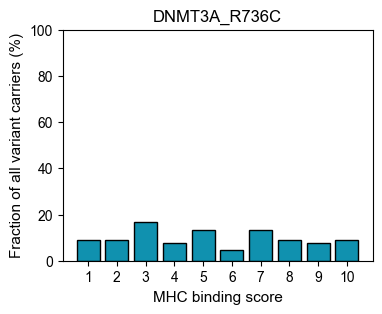

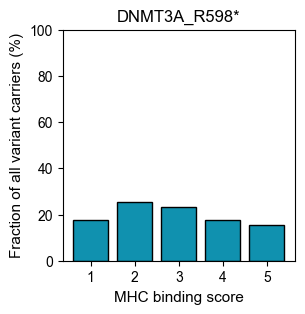

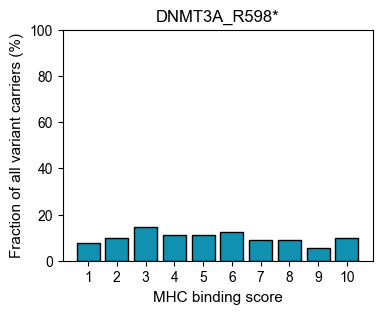

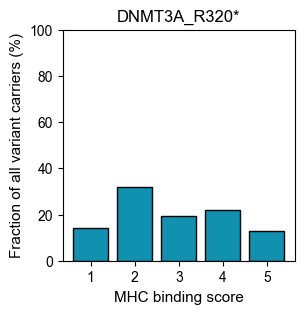

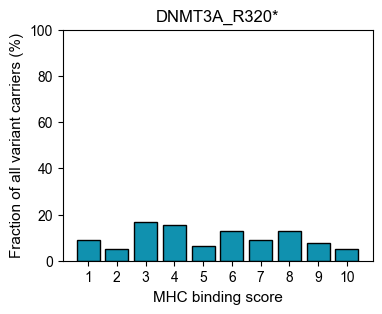

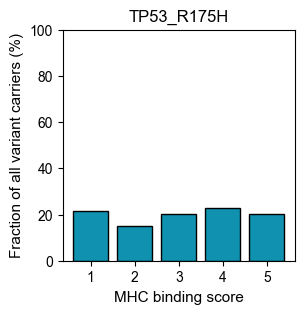

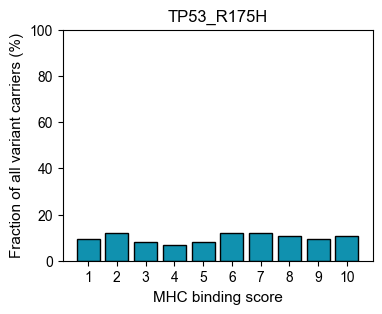

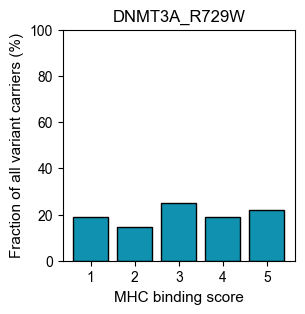

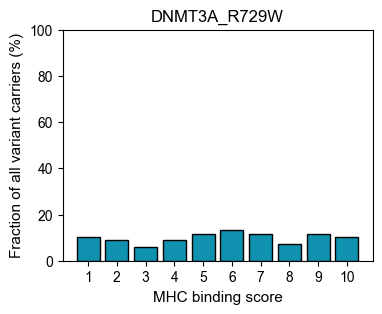

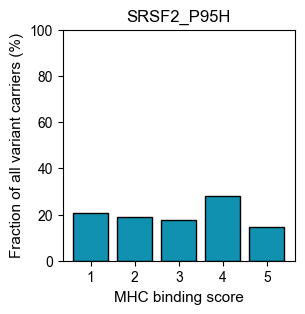

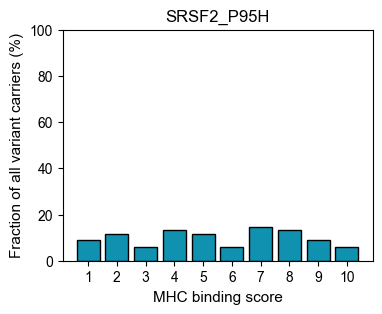

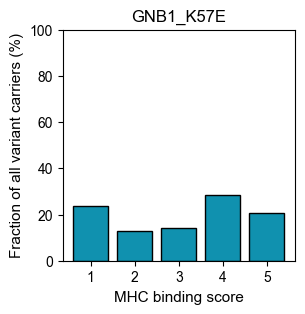

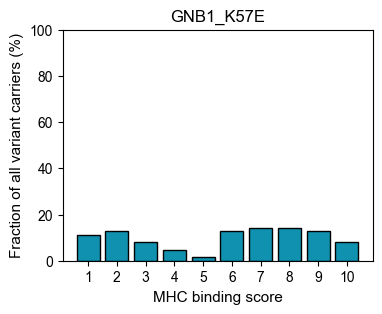

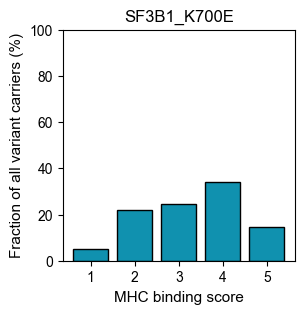

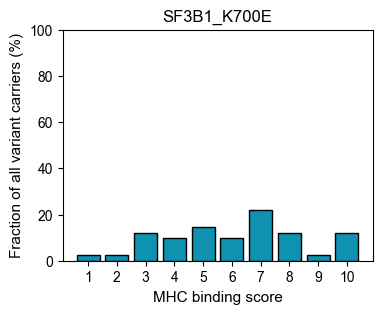

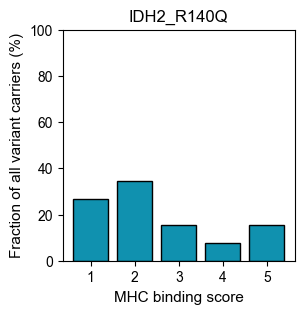

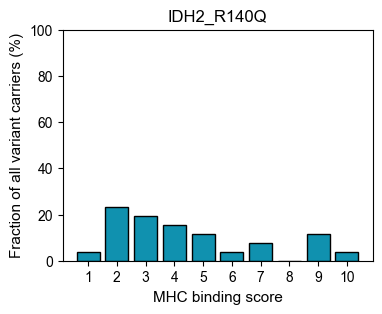

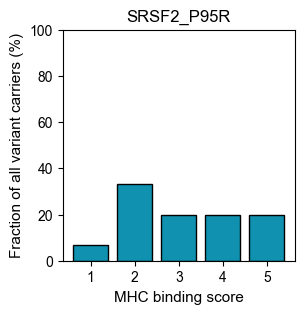

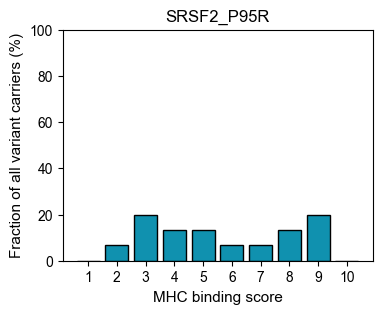

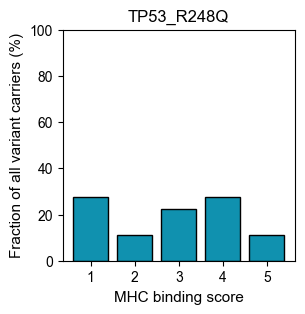

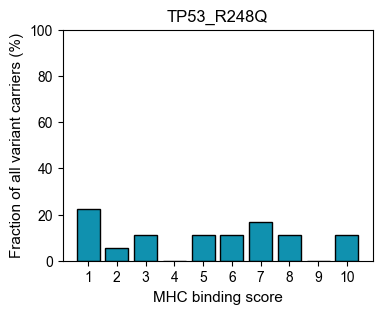

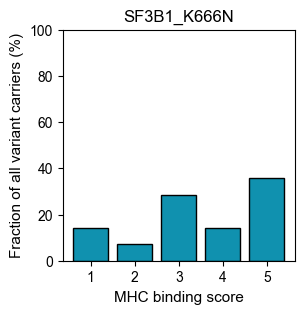

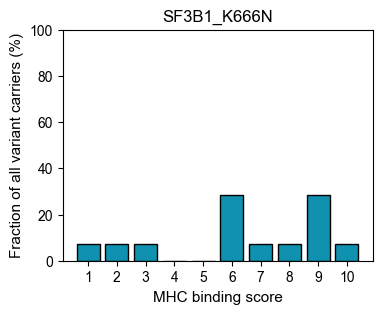

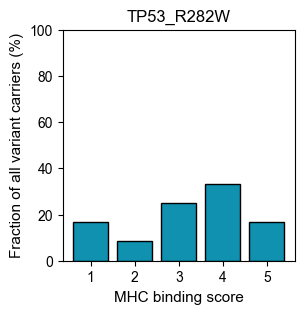

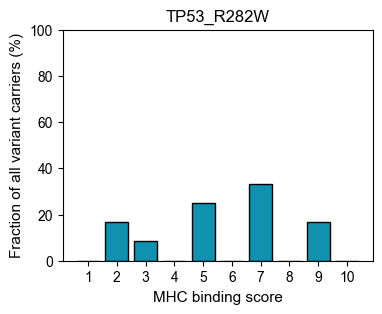

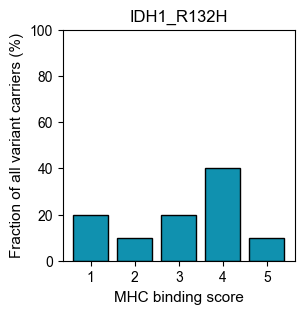

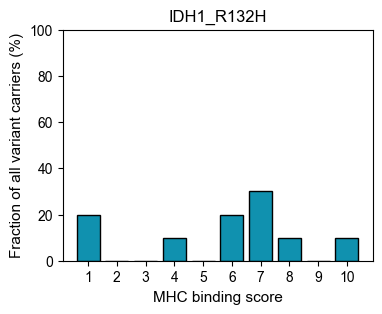

In [28]:

# loop for all variants

scores_5groups = {}
scores_10groups = {}

for var in variants_to_examine:
    # for everyone in the UKBB, add binding score for each variant based on their MHC genotype
    df_all_ukbb_scores = pd.concat([df_clean_hla1_hla_sel, df_clean_hla1_hla_sel.apply(find_best_score_one_variant_log_ref_ch, df=pred_sub_wide, param=param, variant = f'{var}_ch', axis=1)], axis=1)

    # order the df by rank
    df_all_ukbb_scores['rank'] = df_all_ukbb_scores[f'score_{var}_ch'].rank(method='first', ascending=False)
    df_all_ukbb_scores_sort = df_all_ukbb_scores.sort_values(by = 'rank')

    # split people into 3 or 4 groups for each variant (how strongly they bind)
    df_all_ukbb_scores_sort['groups_2'] = split_equal_groups_by_varscore(df_all_ukbb_scores_sort, num_groups = 2, var = var)
    df_all_ukbb_scores_sort['groups_3'] = split_equal_groups_by_varscore(df_all_ukbb_scores_sort, num_groups = 3, var = var)
    df_all_ukbb_scores_sort['groups_4'] = split_equal_groups_by_varscore(df_all_ukbb_scores_sort, num_groups = 4, var = var)
    df_all_ukbb_scores_sort['groups_5'] = split_equal_groups_by_varscore(df_all_ukbb_scores_sort, num_groups = 5, var = var)
    df_all_ukbb_scores_sort['groups_10'] = split_equal_groups_by_varscore(df_all_ukbb_scores_sort, num_groups = 10, var = var)

    # okay now we need to add a column to indicate if that person has CH driven by this variant
    # identify IDs of people with the variant
    ids_var = batch_gene_vars[batch_gene_vars['gene_var']==var].Person_ID.tolist()
    df_all_ukbb_scores_sort[f'{var}_positive'] = df_all_ukbb_scores_sort.Person_ID.isin(ids_var) # added True if someone has the variant, False otherwise 

    # calculate % of people in each of the 5 or 10 groups (as % of total CH positive cases)
    counts5 = df_all_ukbb_scores_sort.groupby('groups_5')[f'{var}_positive'].sum().reset_index()
    counts5['percentage_all_cases'] = counts5[f'{var}_positive'] / counts5[f'{var}_positive'].sum() * 100
    counts10 = df_all_ukbb_scores_sort.groupby('groups_10')[f'{var}_positive'].sum().reset_index()
    counts10['percentage_all_cases'] = counts10[f'{var}_positive'] / counts10[f'{var}_positive'].sum() * 100
    
    # add data to the dictionary 
    scores_5groups[var] = counts5
    scores_10groups[var] = counts10

    # plotting 
    plt.figure(figsize = (3,3))
    plt.bar(counts5['groups_5'], counts5['percentage_all_cases'], color = '#1091af', edgecolor = 'black')
    plt.ylim(0, 100)
    plt.xticks([1, 2, 3, 4, 5], fontsize = 10)
    plt.xlabel('MHC binding score', fontsize = 11)
    plt.ylabel('Fraction of all variant carriers (%)', fontsize = 11)
    plt.title(f'{var}', fontsize = 12)
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_compare_fraction_cases_by_mhc_bind_{var}_group5.pdf', bbox_inches='tight')

    plt.figure(figsize = (4,3))
    plt.bar(counts10['groups_10'], counts10['percentage_all_cases'], color = '#1091af', edgecolor = 'black')
    plt.ylim(0, 100)
    plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], fontsize = 10)
    plt.xlabel('MHC binding score', fontsize = 11)
    plt.ylabel('Fraction of all variant carriers (%)', fontsize = 11)
    plt.title(f'{var}', fontsize = 12)
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_compare_fraction_cases_by_mhc_bind_{var}_group10.pdf', bbox_inches='tight')


In [56]:

# Compare the number of cases in top and bottom group
# Groups are of equal sizes, so no need to worry about this in particular 

# first get dfs
scores_5groups_df = pd.DataFrame()

for key, value in scores_5groups.items():
    temp_df = scores_5groups[key]
    temp_df['gene_var'] = key
    temp_df.rename(columns = {f'{key}_positive':'CH_variant_positive'}, inplace = True)
    scores_5groups_df = pd.concat([scores_5groups_df, temp_df], axis=0)

scores_10groups_df = pd.DataFrame()

for key, value in scores_10groups.items():
    temp_df = scores_10groups[key]
    temp_df['gene_var'] = key
    temp_df.rename(columns = {f'{key}_positive':'CH_variant_positive'}, inplace = True)
    scores_10groups_df = pd.concat([scores_10groups_df, temp_df], axis=0)


In [122]:
# I think one way we can analyse this is for each variant, plot the difference between top and bottom group, normalized by the total nr of people
scores_5groups_counts = pd.merge(scores_5groups_df, genevar_counts, on = 'gene_var')
scores_10groups_counts = pd.merge(scores_10groups_df, genevar_counts, on = 'gene_var')
scores_10groups_counts

# define a way to 
def percentage_difference(group, nr_groups):

    x_a = group.loc[group[f'groups_{nr_groups}'] == 1, 'CH_variant_positive'].iloc[0]  # Value of column X where Y is 'a'
    x_b = group.loc[group[f'groups_{nr_groups}'] == nr_groups, 'CH_variant_positive'].iloc[0]  # Value of column X where Y is 'b'
    
    result = (x_b - x_a) / x_a * 100
    return result

def normalized_difference(group, nr_groups):

    x_a = group.loc[group[f'groups_{nr_groups}'] == 1, 'CH_variant_positive'].iloc[0]  # Value of column X where Y is 'a'
    x_b = group.loc[group[f'groups_{nr_groups}'] == nr_groups, 'CH_variant_positive'].iloc[0]  # Value of column X where Y is 'b'
    num_observations = group['count']   # Number of observations in this category
    
    result = (x_b - x_a) / num_observations * 100
    return result

# Group by Category and apply the custom calculation function
result_5groups1 = pd.DataFrame(scores_5groups_counts.groupby('gene_var').apply(percentage_difference, nr_groups = 5))
result_5groups2 = pd.DataFrame(scores_5groups_counts.groupby('gene_var').apply(normalized_difference, nr_groups = 5))
result_5groups = pd.merge(result_5groups1, result_5groups2, on = 'gene_var')
result_5groups = result_5groups.groupby('gene_var').first().reset_index()
result_5groups.columns.values[1] = 'percentage_diff'
result_5groups.columns.values[2] = 'norm_diff'

result_10groups1 = pd.DataFrame(scores_10groups_counts.groupby('gene_var').apply(percentage_difference, nr_groups = 10))
result_10groups2 = pd.DataFrame(scores_10groups_counts.groupby('gene_var').apply(normalized_difference, nr_groups = 10))
result_10groups = pd.merge(result_10groups1, result_10groups2, on = 'gene_var')
result_10groups = result_10groups.groupby('gene_var').first().reset_index()
result_10groups.columns.values[1] = 'percentage_diff'
result_10groups.columns.values[2] = 'norm_diff'


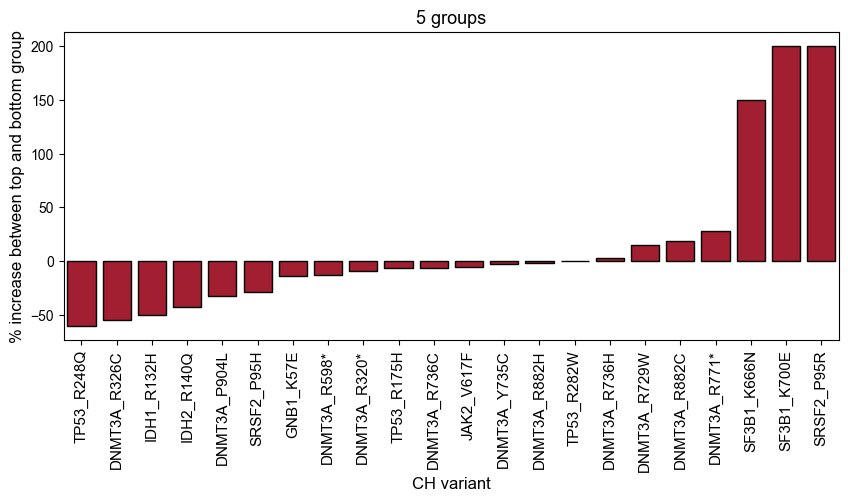

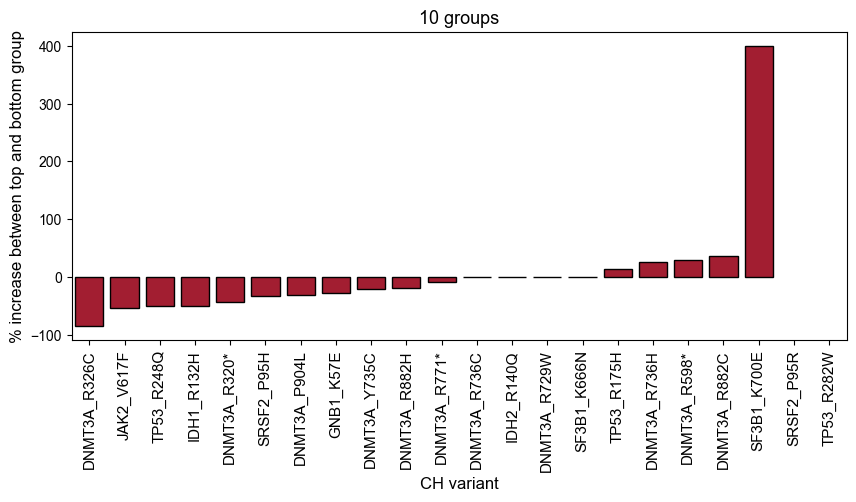

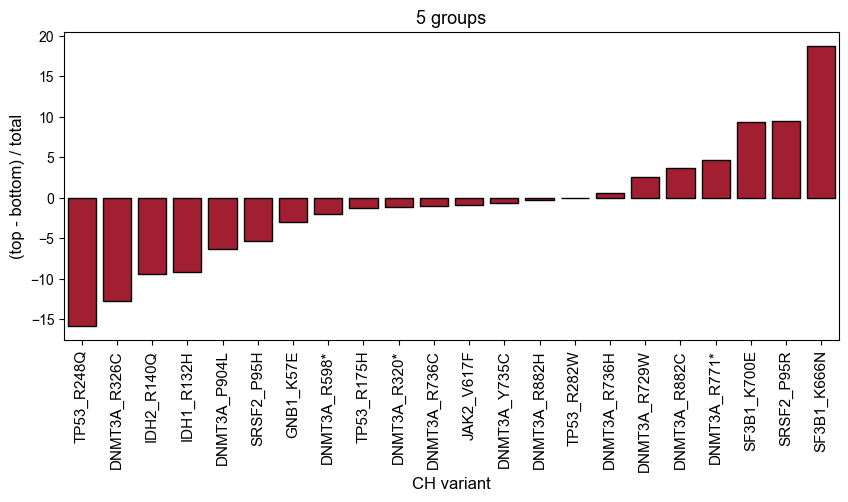

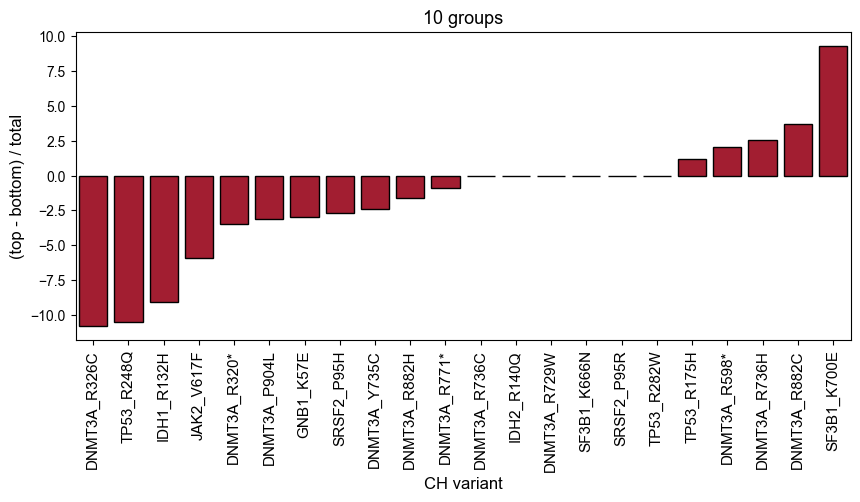

In [130]:

# plot results
order_percent5 = result_5groups.sort_values(by = 'percentage_diff').gene_var.tolist()
order_norm5 = result_5groups.sort_values(by = 'norm_diff').gene_var.tolist()
order_percent10 = result_10groups.sort_values(by = 'percentage_diff').gene_var.tolist()
order_norm10 = result_10groups.sort_values(by = 'norm_diff').gene_var.tolist()

plt.figure(figsize = (10, 4))
sns.barplot(data = result_5groups, x = 'gene_var', y = 'percentage_diff', color = '#B80821', edgecolor = 'black', order = order_percent5)
plt.xlabel('CH variant', fontsize = 12)
plt.ylabel('% increase between top and bottom group', fontsize = 12)
plt.xticks(rotation = 90, fontsize = 11)
plt.title('5 groups', fontsize = 13)
plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_compare_percent_diff_group_1_5.pdf', bbox_inches='tight')

plt.figure(figsize = (10, 4))
sns.barplot(data = result_10groups, x = 'gene_var', y = 'percentage_diff', color = '#B80821', edgecolor = 'black', order = order_percent10)
plt.xlabel('CH variant', fontsize = 12)
plt.ylabel('% increase between top and bottom group', fontsize = 12)
plt.xticks(rotation = 90, fontsize = 11)
plt.title('10 groups', fontsize = 13)
plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_compare_percent_diff_group_1_10.pdf', bbox_inches='tight')

plt.figure(figsize = (10, 4))
sns.barplot(data = result_5groups, x = 'gene_var', y = 'norm_diff', color = '#B80821', edgecolor = 'black', order = order_norm5)
plt.xlabel('CH variant', fontsize = 12)
plt.ylabel('(top - bottom) / total', fontsize = 12)
plt.xticks(rotation = 90, fontsize = 11)
plt.title('5 groups', fontsize = 13)
plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_compare_norm_diff_group_1_5.pdf', bbox_inches='tight')

plt.figure(figsize = (10, 4))
sns.barplot(data = result_10groups, x = 'gene_var', y = 'norm_diff', color = '#B80821', edgecolor = 'black', order = order_norm10)
plt.xlabel('CH variant', fontsize = 12)
plt.ylabel('(top - bottom) / total', fontsize = 12)
plt.xticks(rotation = 90, fontsize = 11)
plt.title('10 groups', fontsize = 13)
plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_compare_norm_diff_group_1_10.pdf', bbox_inches='tight')

In [167]:
# also thinking of other ways of potentially doing this 

# compare percentage of cases in top two groups vs percentage of cases in bottom two groups
def compare_numbers_top_bottom(group, nr_groups):

    x_a = group.loc[group[f'groups_{nr_groups}'].isin([1,2]), 'CH_variant_positive'].iloc[0]  # nr of CH cases in bottom two groups
    x_b = group.loc[group[f'groups_{nr_groups}'].isin([nr_groups, nr_groups-1]), 'CH_variant_positive'].iloc[0]  # nr of CH cases in top two group
    num_observations = group['count'] 
    result = (x_b - x_a) / num_observations
    
    return result

result_5groups_percentages = pd.DataFrame(scores_5groups_counts.groupby('gene_var').apply(compare_numbers_top_bottom, nr_groups = 5))


: 

In [165]:
def absolute_difference(group, nr_groups):

    x_a = group.loc[group[f'groups_{nr_groups}'] == 1, 'CH_variant_positive'].iloc[0]  # Value of column X where Y is 'a'
    x_b = group.loc[group[f'groups_{nr_groups}'] == nr_groups, 'CH_variant_positive'].iloc[0]  # Value of column X where Y is 'b'
    
    result = (x_b - x_a) 
    return result

result_5groups_abs_diff = pd.DataFrame(scores_5groups_counts.groupby('gene_var').apply(absolute_difference, nr_groups = 5))
result_5groups_abs_diff.rename(columns={result_5groups_abs_diff.columns[0]: 'difference'}, inplace=True)
result_5groups_abs_diff.reset_index(inplace = True)

# add number of all cases
result_5groups_abs_diff_counts = pd.merge(result_5groups_abs_diff, genevar_counts, on = 'gene_var')
